# 필요한 라이브러리

In [1]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from torchvision import datasets, transforms
from skimage.color import rgb2gray, gray2rgb
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# 변수값 지정

In [2]:
test_batch_size = 1

no_cuda = False

# 전체 테스트 데이터 저장경로
test_data_paths = glob.glob('data/*.jpg')

# 랜덤 인덱스 이용해 랜덤 이미지로 과업 수행
rnd_test_datas = np.random.choice(test_data_paths, 3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 이미지 전처리
- 테스트 이미지이지만 데이터 수가 적기 때문에 데이터 확대 기법을 적용해서 많은 이미지로 과업들을 수행할 수 있도록 하려 했으나 pretrained된 모델로 과업을 수행할 계획이라 전처리 기법을 많이 적용하지 않을 예정이다.
- 백지연

In [3]:
transforms_lst = transforms.Compose([
    transforms.Resize(400),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# 데이터셋 불러오기
- data폴더 내에 있는 이미지 파일들로 Segmentation과 Inpainting을 수행할 예정이고, 두 과업은 각각 Pretrained된 모델을 가져와서 사용할 것이다.

In [4]:
def get_label(path):
    return os.path.basename(path).split('_')[0]

In [5]:
label_names = [get_label(path) for path in test_data_paths]
classes = np.unique(label_names)
classes

array(['TVmonitor', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
       'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train'],
      dtype='<U11')

In [6]:
class customDataset(torch.utils.data.Dataset):
    def __init__(self, data_paths, transform = None):
        self.data_paths = data_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        path = self.data_paths[idx]
        
        # Read image
        image_pil = Image.open(path)
        
        if self.transform:
            image = self.transform(image_pil)
            
        return image

In [7]:
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers' : 0, 'pin_memory' : True} if use_cuda else {}

In [8]:
test_loader = torch.utils.data.DataLoader(
    customDataset(rnd_test_datas, transforms_lst),
    batch_size = test_batch_size,
    shuffle = False,
    **kwargs
)

# Segmentation 수행
- Segmentation에는 Semantic Segmentation과 Instance Segmentation이 있다.
- Semantic Segmentation은 이미지 내 모든 Object들에 대해 Instance(person1, person2, ...)를 구분하지 않고 특정 class에 속하는 Object들 모두 같게 Segmentation을 수행한다.
- Instance Segmentation은 이미지 내 모든 Object들에 대해 Instance를 구분해서 특정 class에 속하는 Object들 중 Instance별로 다르게 Segmentation을 수행하다.

## Semantic Segmentation 모델
- pretrained된 모델로 FCN(Fully Convolution Network)과 DeeplabV3모델을 사용해서 Semantic Segmentation을 수행할 것이다.

In [9]:
fcn = models.segmentation.fcn_resnet101(pretrained = True).eval()
dlab = models.segmentation.deeplabv3_resnet101(pretrained = True).eval()

In [10]:
image_path = test_data_paths[11]
image_path

'data\\bicycle_10.jpg'

In [11]:
image_pil = Image.open(image_path)
image = np.array(image_pil)
image.shape

(802, 1024, 3)

c:\users\rudck\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


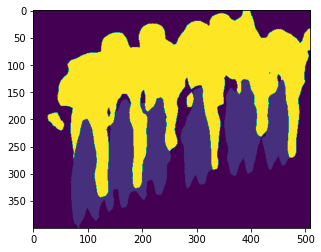

In [12]:
input_image = transforms_lst(image_pil).unsqueeze(0).to(device)
output = fcn.to(device)(input_image)['out']
output_max = torch.argmax(output.squeeze(), dim = 0).detach().cpu().numpy()

plt.imshow(output_max)
plt.show()

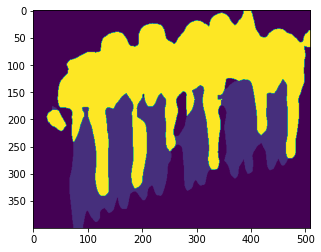

In [13]:
input_image = transforms_lst(image_pil).unsqueeze(0).to(device)
output = dlab.to(device)(input_image)['out']
output_max = torch.argmax(output.squeeze(), dim = 0).detach().cpu().numpy()

plt.imshow(output_max)
plt.show()

In [12]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

In [42]:
from torchvision.models.detection import maskrcnn_resnet50_fpn

mask_r_cnn = maskrcnn_resnet50_fpn(pretrained = True, progress = False)
mask_r_cnn = mask_r_cnn.eval()

output = mask_r_cnn(batch)
output

[{'boxes': tensor([[109.2658,   8.8374, 198.3548, 219.8713],
          [ 10.6935,  21.6310, 112.8048, 215.2423],
          [198.2160, 138.2568, 222.9349, 218.4517],
          [ 65.8371, 194.3155, 112.2547, 222.4762],
          [ 78.1220,  47.6188,  98.9928, 104.4838],
          [116.4284,  45.5833, 136.4954,  90.1501],
          [110.6524,   5.3117, 129.8358,  68.8692],
          [173.8485,  45.5783, 201.1491, 219.2997],
          [ 11.0137, 167.1029,  35.5028, 190.6734],
          [103.4366,  55.6209, 122.0391, 117.6483],
          [ 67.1405, 193.5946, 113.1321, 223.1966],
          [106.0333,  51.1163, 140.3951, 216.5863],
          [108.9922,   3.6331, 137.0535,  99.9826],
          [ 90.8851,  41.4190, 107.7336, 110.9365],
          [185.8389, 127.2077, 218.9248, 223.5303],
          [ 77.9021,  31.5327, 143.5847, 222.2890],
          [109.5746,  45.5060, 131.6236, 116.6600],
          [ 21.0838, 122.1593,  37.2025, 183.2912],
          [  8.0243,  97.9523,  34.7221, 183.7725],
   

In [ ]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

inst_class_to_idx = {cls : idx for (idx, cls) in enumerate(inst_classes)}

In [44]:
len(output)

2

In [45]:
person_output, bicycle_output = output[0], output[1]
person_masks, bicycle_masks = person_output['masks'], bicycle_output['masks']
print(f'shape = {person_masks.shape}, dtype = {bicycle_masks.dtype}, '
      f'min = {person_masks.min()}, max = {bicycle_masks.max()}')

shape = torch.Size([47, 1, 224, 224]), dtype = torch.float32, min = 0.0, max = 0.9991879463195801


In [46]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

inst_class_to_idx = {cls : idx for (idx, cls) in enumerate(inst_classes)}

print('For the first person, the following instances were detected : ')
print([inst_classes[label] for label in person_output['labels']])

For the first person, the following instances were detected : 
['person', 'person', 'person', 'bench', 'person', 'person', 'person', 'person', 'person', 'person', 'chair', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'elephant', 'person', 'person', 'person', 'bench', 'person', 'person', 'person', 'person', 'handbag', 'person', 'person', 'person', 'person', 'person', 'horse', 'person', 'person', 'person', 'person', 'umbrella', 'person', 'person', 'person', 'person', 'person']


shape = torch.Size([47, 1, 224, 224]), dtype = torch.bool


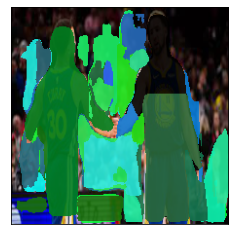

In [47]:
proba_threshold = 0.5
person_bool_masks = person_output['masks'] > proba_threshold
print(f'shape = {person_bool_masks.shape}, dtype = {person_bool_masks.dtype}')

person_bool_masks = person_bool_masks.squeeze(1)

show(draw_segmentation_masks(person1_int, person_bool_masks, alpha = 0.9))

shape = torch.Size([37, 1, 224, 224]), dtype = torch.bool


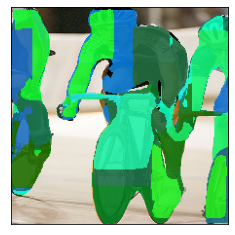

In [52]:
bicycle_bool_masks = bicycle_output['masks'] > proba_threshold
print(f'shape = {bicycle_bool_masks.shape}, dtype = {bicycle_bool_masks.dtype}')

bicycle_bool_masks = bicycle_bool_masks.squeeze(1)

show(draw_segmentation_masks(bicycle1_int, bicycle_bool_masks, alpha = 0.9))

# Inpainting 수행